In [52]:
from numba.cuda.cudadrv import enums
from numba import cuda

In [53]:
!wget -O img.jpeg https://file.io.vn/W3MG0J

--2025-10-07 09:21:19--  https://file.io.vn/W3MG0J
Resolving file.io.vn (file.io.vn)... 157.10.45.101
Connecting to file.io.vn (file.io.vn)|157.10.45.101|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://my.microsoftpersonalcontent.com/personal/de4e2fbd58f4f53b/_layouts/15/download.aspx?UniqueId=2375f846-15de-42e9-87e9-c31e5bebf509&Translate=false&tempauth=v1e.eyJzaXRlaWQiOiJiMWVkOTQ5Mi0wMDA3LTRhNWEtYjJmOC05MzA4OWQ4YzgwMmQiLCJhcHBfZGlzcGxheW5hbWUiOiJpaW5kZXgiLCJhcHBpZCI6ImQ4NWE5YTNhLTM4MzktNDkzMC05ZjE0LTgxOGEyZDQ0OWE0ZCIsImF1ZCI6IjAwMDAwMDAzLTAwMDAtMGZmMS1jZTAwLTAwMDAwMDAwMDAwMC9teS5taWNyb3NvZnRwZXJzb25hbGNvbnRlbnQuY29tQDkxODgwNDBkLTZjNjctNGM1Yi1iMTEyLTM2YTMwNGI2NmRhZCIsImV4cCI6IjE3NTk4MzI0ODAifQ.aktkPF3zRGPrQV87mFofPz4srGjYsvr2_LFoSZF6xjWLJWyW-oJm_SrE5r3kApTBIDvXceNkKkasGKKcm1Q54GHYS8rAM_qXuujhoQVH90VoLhRe1q3JAJ-OLdxlYj6vHmrsqs10fY4RcRwQYhnWY6yQKBXhOP4bHvEIOBJgLK0e6XOHSFeG1i23M8Zhx6r7eZ-yUuMMICAR7primZBqDN3U12xJflBFDjmzBHlBBTAUIH7RU9yolb-L_oMxPM3mt

In [54]:
# from matplotlib import pyplot
import matplotlib

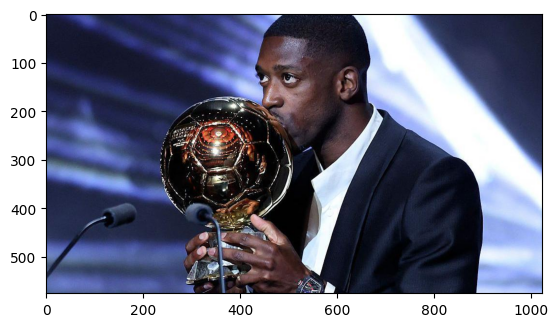

In [55]:
#Load the image
img = matplotlib.pyplot.imread('img.jpeg')

matplotlib.pyplot.imshow(img)

In [56]:
height, width, channels = img.shape
rgb_1d = img.reshape(height * width * 3)
rgb_2d = img.reshape(height, width, 3)

In [57]:
import time

In [58]:
from numba import jit, int32, float32
import numpy as np
from numba import config
import matplotlib.pyplot as plt
config.CUDA_ENABLE_PYNVJITLINK = 1
import math

In [59]:
size = 7
sigma = 1.5
kernel = np.zeros((size, size), dtype=np.float32)
center = size // 2

for i in range(size):
    for j in range(size):
        x = i - center
        y = j - center
        kernel[i, j] = (1.0 / (2.0 * math.pi * sigma**2)) * \
                      math.exp(-(x**2 + y**2) / (2.0 * sigma**2))

kernel = kernel / np.sum(kernel)

print(kernel)


[[0.00134197 0.00407653 0.00794    0.00991586 0.00794    0.00407653
  0.00134197]
 [0.00407653 0.01238341 0.02411958 0.03012171 0.02411958 0.01238341
  0.00407653]
 [0.00794    0.02411958 0.04697853 0.05866909 0.04697853 0.02411958
  0.00794   ]
 [0.00991586 0.03012171 0.05866909 0.07326882 0.05866909 0.03012171
  0.00991586]
 [0.00794    0.02411958 0.04697853 0.05866909 0.04697853 0.02411958
  0.00794   ]
 [0.00407653 0.01238341 0.02411958 0.03012171 0.02411958 0.01238341
  0.00407653]
 [0.00134197 0.00407653 0.00794    0.00991586 0.00794    0.00407653
  0.00134197]]


In [ ]:
@cuda.jit
def gaussian_blur_no_shared(src, dst, kernel, kernel_size):
    x = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    y = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

    height, width = src.shape[0], src.shape[1]
    half_k = kernel_size // 2

    if x < width and y < height:
        sum_r = 0.0
        sum_g = 0.0
        sum_b = 0.0

        for ky in range(kernel_size):
            for kx in range(kernel_size):
                src_y = y + ky - half_k
                src_x = x + kx - half_k

                src_y = max(0, min(height - 1, src_y))
                src_x = max(0, min(width - 1, src_x))

                weight = kernel[ky, kx]

                sum_r += src[src_y, src_x, 0] * weight
                sum_g += src[src_y, src_x, 1] * weight
                sum_b += src[src_y, src_x, 2] * weight

        dst[y, x, 0] = min(255, max(0, sum_r)) # sum_r are float, some how this still work =))
        dst[y, x, 1] = min(255, max(0, sum_g))
        dst[y, x, 2] = min(255, max(0, sum_b))

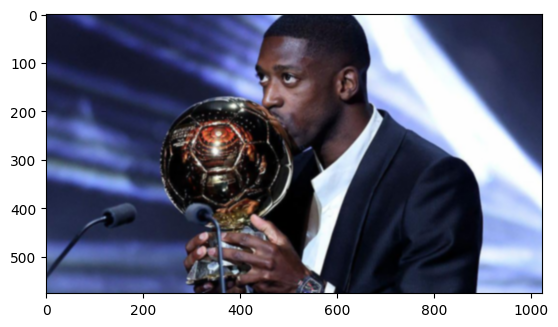

In [67]:
threads_per_block = (16, 16)

blocks_per_grid_x = (width + threads_per_block[0] - 1) // threads_per_block[0]
blocks_per_grid_y = (height + threads_per_block[1] - 1) // threads_per_block[1]
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

# Allocate memory
blur_no_shared = np.empty_like(rgb_2d)

devSrc = cuda.to_device(rgb_2d)
devKernel = cuda.to_device(kernel)
devDst_no_shared = cuda.to_device(blur_no_shared)
devDst_shared = cuda.to_device(kernel)

start_no_shared = time.time()
gaussian_blur_no_shared[blocks_per_grid, threads_per_block](
    devSrc, devDst_no_shared, devKernel, 7
)
end_no_shared = time.time()
result_no_shared = devDst_no_shared.copy_to_host()
time_no_shared = end_no_shared - start_no_shared

matplotlib.pyplot.imshow(result_no_shared)